In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


Setup

In [2]:
# install voxelmorph
import tensorflow as tf
if not tf.__version__.startswith('2.15'):
  # install older tensorflow version since voxelmorph is not compatible with current build
  !pip uninstall -y tensorflow
  !pip install tensorflow==2.15
!pip install voxelmorph
!pip install neurite

  Using cached voxelmorph-0.2-py3-none-any.whl.metadata (660 bytes)
Using cached voxelmorph-0.2-py3-none-any.whl (54 kB)


In [3]:
# import voxelmorph
import voxelmorph as vxm
import neurite as ne

import os
import urllib.request
import zipfile
import json
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import cv2

Download dataset

In [4]:
# download dataset
filename = 'COMULISSHGBF.zip'
if not os.path.exists(filename):
    url = 'https://cloud.imi.uni-luebeck.de/s/QQKxdTGoLPmEbc4/download/COMULISSHGBF.zip'
    urllib.request.urlretrieve(url, filename)

    # extract files
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('./')

In [5]:
def load_data(jsonData, dataFolderPath, filterString='0001'):
    training_paths = []
    for i in range(len(jsonData['training_paired_images'])):
        tmproot, tmpext = os.path.splitext(jsonData['training_paired_images'][i]['moving'])
        root, ext = os.path.splitext(tmproot)
        splitRoot = root.split('_')
        if splitRoot[-1] == filterString:
            training_paths.append(jsonData['training_paired_images'][i])

    fixedData = []
    movingData = []
    for image in training_paths:
        fixedImg = nib.load(dataFolderPath + image['fixed'].removeprefix('.')).get_fdata()
        fixedData.append(fixedImg.astype(np.uint8))
        movingImg = nib.load(dataFolderPath + image['moving'].removeprefix('.')).get_fdata()
        movingImg_reshaped = movingImg.reshape(jsonData['tensorImageShape'][0]['0'][0], jsonData['tensorImageShape'][0]['0'][1], 3)
        movingData.append(movingImg_reshaped.astype(np.uint8))

    return np.array(fixedData), np.array(movingData)

In [6]:
with open('./COMULISSHGBF/COMULISSHGBF_dataset.json', 'r') as file:
  data_json = json.load(file)
dataFolder = './COMULISSHGBF'
data_fixed_raw, data_moved_raw = load_data(data_json, dataFolder)

(-0.5, 833.5, 833.5, -0.5)

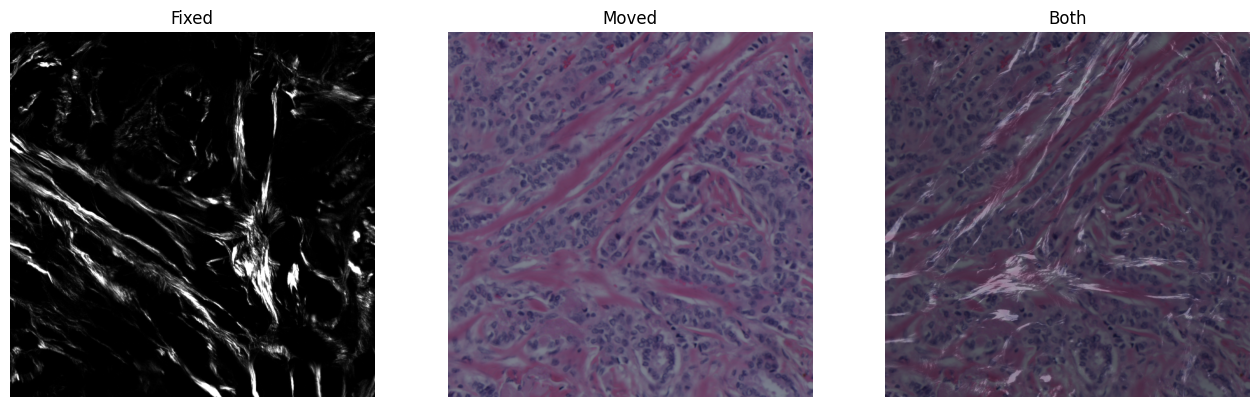

In [40]:
img = 6

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16,8))
ax0.imshow(data_fixed_raw[img],cmap='gray')
ax0.set_title("Fixed")
ax0.axis("off")
ax1.imshow(data_moved_raw[img])
ax1.set_title("Moved")
ax1.axis("off")
ax2.imshow(data_fixed_raw[img],cmap='gray')
ax2.imshow(data_moved_raw[img], alpha=0.7)
ax2.set_title("Both")
ax2.axis("off")

Prepare Data

In [9]:
img_h ,img_w = data_json['tensorImageShape'][0]['0']

### GOOD IDEA??
# Invert fixed images
data_fixed_inv = 1 - data_fixed_raw

# Get moved images as grayscales
data_moved_gray = np.zeros_like(data_fixed_raw)
for idx, val in enumerate(data_moved_raw):
    data_moved_gray[idx, :, :, 0] = cv2.cvtColor(val, cv2.COLOR_RGB2GRAY)

# Normalize the images
data_fixed_normalized = data_fixed_inv / np.max(data_fixed_inv)
data_moved_normalized = data_moved_gray / np.max(data_moved_gray)


### RESIZE instead??
# Pad images
pad_amount = ((0, 0), ((1024-img_w)//2,(1024-img_w)//2), ((1024-img_h)//2,(1024-img_h)//2), (0,0))
data_fixed_normalized = np.pad(data_fixed_normalized, pad_amount, 'constant')
data_moved_normalized = np.pad(data_moved_normalized, pad_amount, 'constant')

In [10]:
data_fixed_normalized.shape

(166, 1024, 1024, 1)

In [11]:
data_moved_normalized.shape

(166, 1024, 1024, 1)

(-0.5, 1023.5, 1023.5, -0.5)

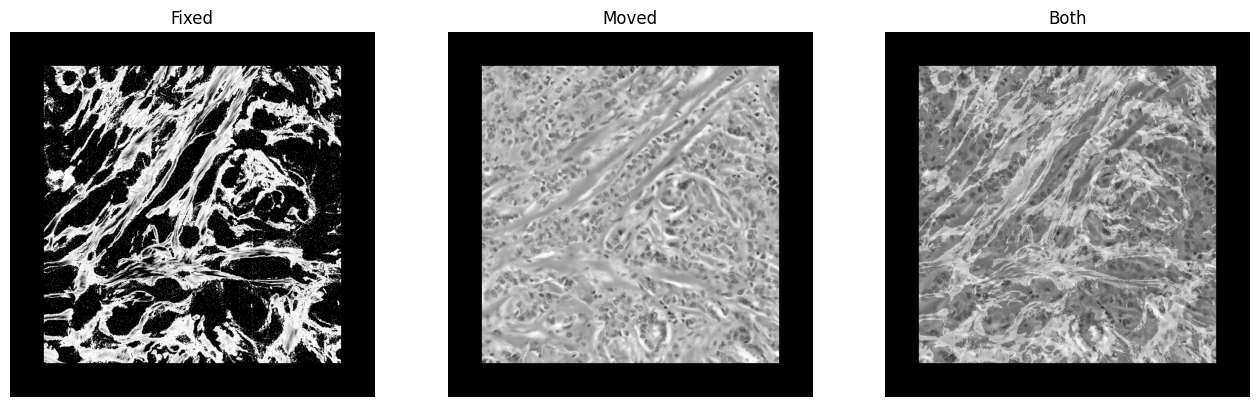

In [12]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16,8))
ax0.imshow(data_fixed_normalized[img],cmap='gray')
ax0.set_title("Fixed")
ax0.axis("off")
ax1.imshow(data_moved_normalized[img],cmap='gray')
ax1.set_title("Moved")
ax1.axis("off")
ax2.imshow(data_fixed_normalized[img],cmap='gray')
ax2.imshow(data_moved_normalized[img],cmap='gray', alpha=0.7)
ax2.set_title("Both")
ax2.axis("off")

Define Model

In [13]:
# Define the input shapes
inshape = data_fixed_normalized.shape[1:3]
nb_features = [
    [64, 128, 256, 512],  # Encoder-Kanäle
    [512, 256, 128, 64, 32]  # Decoder-Kanäle
]

# build model using VxmDense
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

print('input shape: ', ', '.join([str(t.shape) for t in vxm_model.inputs]))
print('output shape:', ', '.join([str(t.shape) for t in vxm_model.outputs]))

input shape:  (None, 1024, 1024, 1), (None, 1024, 1024, 1)
output shape: (None, 1024, 1024, 1), (None, 1024, 1024, 2)


In [14]:
# voxelmorph has a variety of custom loss classes
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter
lambda_param = 0.05
loss_weights = [1, lambda_param]

In [15]:
vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)

Train model

In [86]:
def vxm_data_generator(fixed, moved, batch_size=32):
    # preliminary sizing
    vol_shape = fixed.shape[1:3] # extract data shape
    ndims = len(vol_shape)

    # prepare a zero array the size of the deformation
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])

    while True:
        idx = np.random.randint(0, fixed.shape[0], size=batch_size)
        fixed_image = fixed[idx]
        moving_image = moved[idx]

        if np.random.randint(0,2) == 0:
          fixed_image = np.flip(fixed_image,1)
          moving_image = np.flip(moving_image,1)

        for _ in range(np.random.randint(0,4)):
          fixed_image = np.rot90(fixed_image,axes=(1,2))
          moving_image = np.rot90(moving_image,axes=(1,2))

        inputs = [moving_image, fixed_image]
        outputs = [fixed_image, zero_phi]

        yield (inputs, outputs)

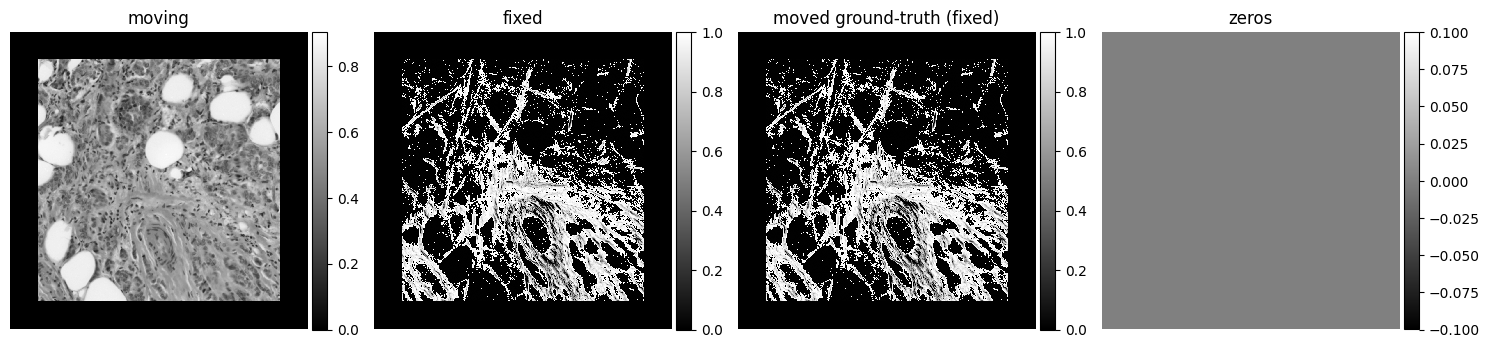

In [91]:
# test generator
train_generator = vxm_data_generator(data_fixed_normalized,data_moved_normalized)
in_sample, out_sample = next(train_generator)

# visualize
images = [img[0, :, :, 0] for img in in_sample + out_sample]
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [ ]:
nb_epochs = 10
steps_per_epoch = 100
hist = vxm_model.fit_generator(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2);